In [ ]:
import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
import statsmodels.api as sm
import matplotlib.pyplot as plt
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [ ]:
df=yf.download("APOLLOHOSP.NS")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
DF=df

Plot

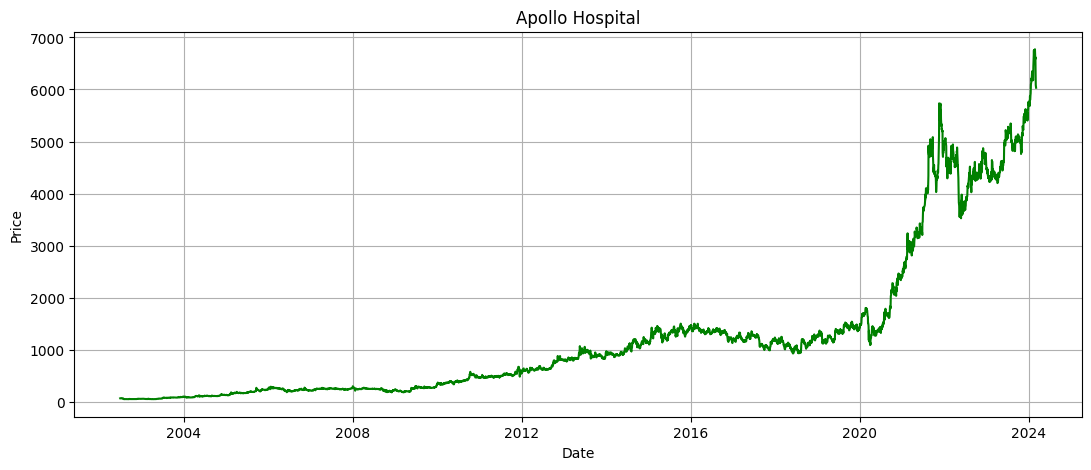

In [ ]:
plt.figure(figsize=(13,5))
plt.grid(True)
#plt.plot(result['predictions'],c='red')
plt.plot(df['Close'],c='green')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Apollo Hospital")
plt.show()

Trend, Seasonal, Residual plots

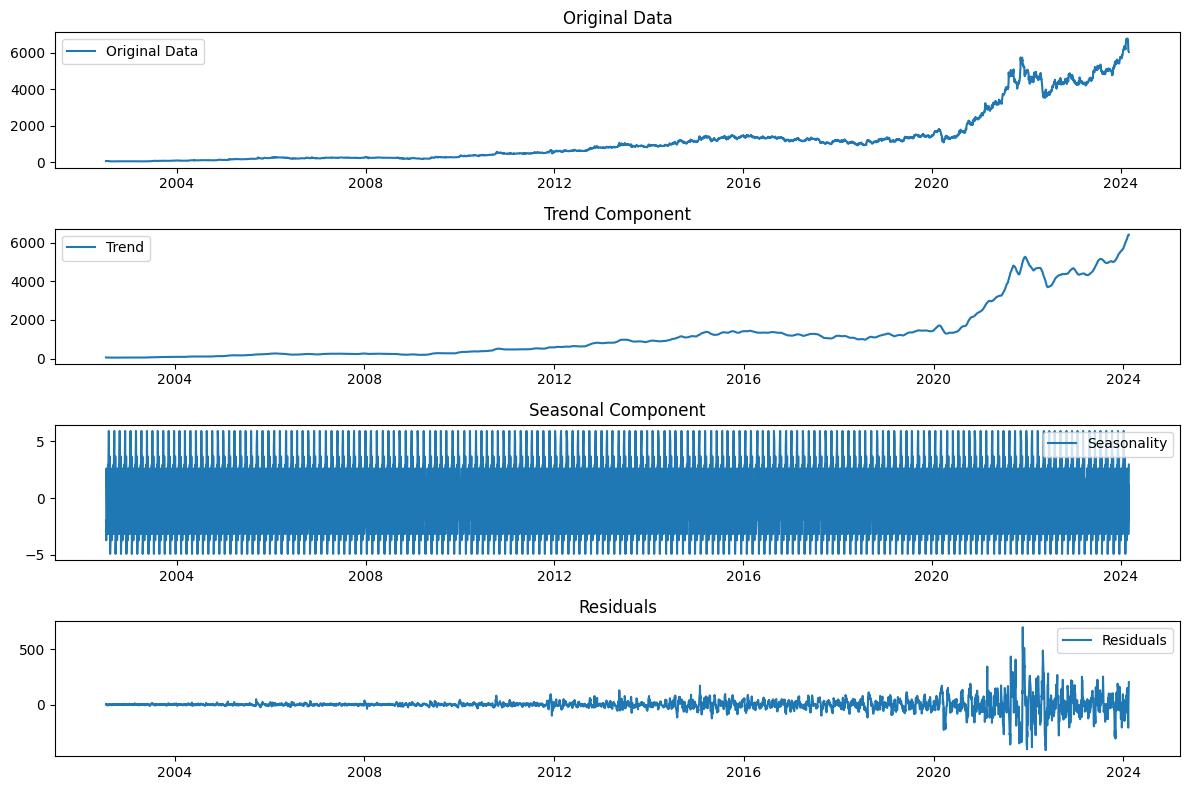

In [ ]:
# STL Decomposition 547
stl_result = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=30)

# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['Close'], label='Original Data')
plt.title('Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(stl_result.trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(stl_result.seasonal, label='Seasonality')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(stl_result.resid, label='Residuals')
plt.title('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

ADF test function

In [ ]:
labels=['Test statistics','P-Value','No of Lags','No of Observations']
def adf_test(close):
    result=adfuller(close)
    for label,value in zip(labels,result):
        print(label," : ",value)
    for i in result[4].items():
        print("Critical value ",pd.Series(i)[0]," : ",pd.Series(i)[1])
    if result[1]<0.05:
        print("P-value less than 0.05, hence Null hypothesis can be rejected\n")
    else:
        print("P-value greater than 0.05, hence Null hypothesis can't be rejected")

In [ ]:
adf_test(df['Close'])

Test statistics  :  2.4132692350236735
P-Value  :  0.999016418018785
No of Lags  :  29
No of Observations  :  5354
Critical value  1%  :  -3.4315719719830122
Critical value  5%  :  -2.8620799873379568
Critical value  10%  :  -2.5670574345637776
P-value greater than 0.05, hence Null hypothesis can't be rejected


Differencing

In [ ]:
df['first differencing']=df['Close']-df['Close'].shift(1)

In [ ]:
df['second differencing']=df['first differencing']-df['first differencing'].shift(1)

Testing Hypothesis

In [ ]:
adf_test(df['second differencing'].dropna())

Test statistics  :  -21.67490141165569
P-Value  :  0.0
No of Lags  :  33
No of Observations  :  5348
Critical value  1%  :  -3.4315733435902627
Critical value  5%  :  -2.8620805933241917
Critical value  10%  :  -2.5670577571509128
P-value less than 0.05, hence Null hypothesis can be rejected



Differencing plots

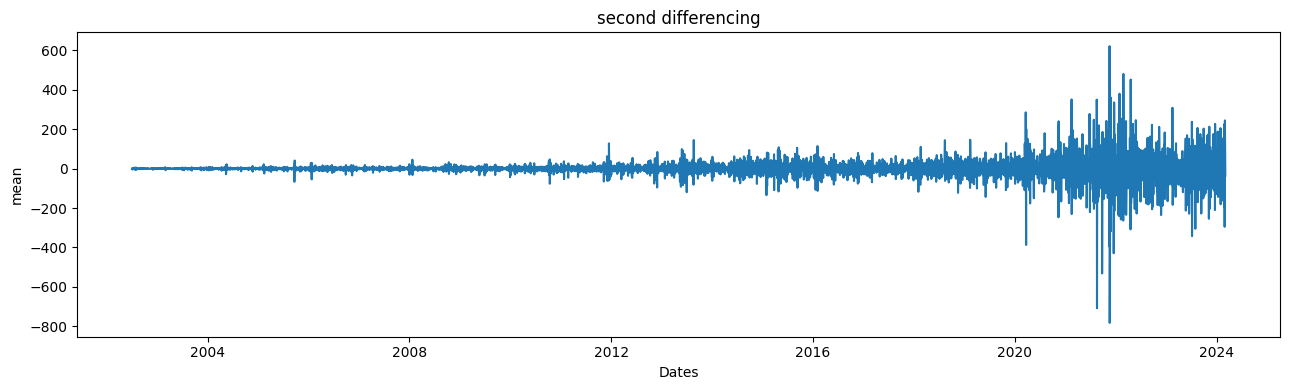

In [ ]:
plt.figure(figsize=(13,4))
plt.plot(df['second differencing'])
plt.ylabel("mean")
plt.xlabel("Dates")
plt.title("second differencing")
plt.tight_layout()
plt.show()

ACF, PACF plots

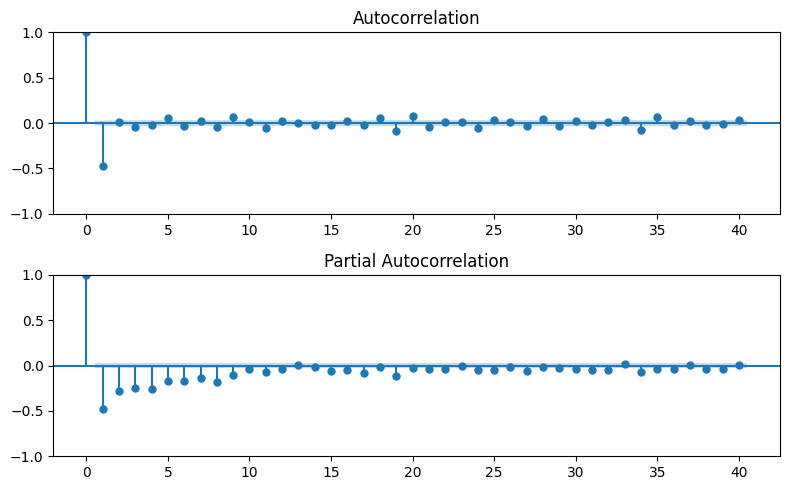

In [ ]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(211)
acf=sm.graphics.tsa.plot_acf(df['second differencing'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['second differencing'].dropna(),lags=40,ax=ax2)
plt.tight_layout()

Splitting data

In [ ]:
train_data,test_data=df['Close'][0:(int(len(df.Close)*0.9))],df['Close'][(int(len(df.Close)*0.9)):]

--------------------------------------------GRID SEARCH----------------------------------------------

Finding P,D,Q values using Auto-Arima

In [ ]:
model_autoARIMA = auto_arima(df.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=30,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,1)[30]             : AIC=inf, Time=116.29 sec
 ARIMA(0,2,0)(0,2,0)[30]             : AIC=66476.378, Time=4.17 sec


Using nested Loops(ARIMA)

In [ ]:
p_values = range(0, 10)  #[0, 1]
d_values = range(0, 3)
q_values = range(0, 5)
smallest_rmse=float('inf')
seasonal_periods = [x for x in range(2,11)]

In [ ]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = sm.tsa.ARIMA(train_data, order=order).fit()
            predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
            error = mean_squared_error(test_data, predictions)
            print('ARIMA%s RMSE=%.3f' % (order,sqrt(error)))
            #finding best RMSE and order
            if sqrt(error)<smallest_rmse:
                smallest_rmse=sqrt(error)
                best_order=order
print('\nSmallest RMSE: %.3f for order %s' %(smallest_rmse,best_order))

Using nested Loops(SARIMA)

In [ ]:
p_values = range(0, 2)  #[0, 1]
d_values = range(0, 2)
q_values = range(0, 2)
smallest_rmse=float('inf')
seasonal_periods = [x for x in range(2,11)]

In [ ]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            for seasonal_period in seasonal_periods:
                order = (p, d, q)
                sorder = (0, 0, 0, seasonal_period)
                warnings.filterwarnings("ignore")

                try:
                    model = sm.tsa.statespace.SARIMAX(train_data, order=order, seasonal_order=sorder).fit()
                    predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
                    mse = mean_squared_error(test_data, predictions)
                    rmse = np.sqrt(mse)

                    print('SARIMA%sx%s RMSE=%.3f' % (order, sorder, rmse))

                    # Update smallest_rmse if current error is smaller
                    if rmse < smallest_rmse:
                        smallest_rmse = rmse
                        best_order = order
                        best_seasonal_order = sorder

                except Exception as e:
                    print(f"Error for order {order} and seasonal order {sorder}: {str(e)}")
                    continue

print('\nSmallest RMSE: %.3f for order %s and seasonal order %s' % (smallest_rmse, best_order, best_seasonal_order))

ARIMA model

In [ ]:
model=sm.tsa.ARIMA(train_data,order=(9, 2, 0))
model_fit=model.fit()

SARIMA model

In [ ]:
'''model=sm.tsa.statespace.SARIMAX(train_data,order=(9, 2, 0),seasonal_order=(0,0,0,30))
model_fit=model.fit()'''

In [ ]:
print(model_fit.summary())

In [ ]:
predictions = []
for i in range(len(test_data)):
    # Fit the model with updated training data
    model = sm.tsa.statespace.SARIMAX(np.concatenate([train_data, test_data.iloc[:i]]), order=(9,2,0),seasonal_order=(0,0,0,30))
    fit_model = model.fit(disp=False)

    # Make one-step-ahead prediction
    pred = fit_model.get_forecast(steps=1)
    yhat = pred.predicted_mean[0]

    # Save the prediction
    predictions.append(yhat)

Rolling Forecast

In [ ]:
result=pd.DataFrame({"predictions":predictions,"test_data":test_data})
result

In [ ]:
r2=r2_score(result['predictions'],result['test_data'])
rmse=math.sqrt(mean_squared_error(result['predictions'],result['test_data']))
mae=mean_absolute_error(result['predictions'],result['test_data'])
print("R2 :",r2)
print("RMSE :",rmse)
print("MAE :",mae)

In [ ]:
#plt.plot(figsize=(15,10))
plt.plot(result['predictions'],c='red',label="predictions")
plt.plot(result['test_data'],c='green',label="actual")
plt.xlabel("date")
plt.ylabel("price")
plt.title("Actual price vs predicted price")
plt.legend()
plt.show()

Future prediction

Seasonal arima

In [ ]:
model_s = sm.tsa.statespace.SARIMAX(df.Close, order=(9,2,1),seasonal_order=(0,0,0,365))
fit_model_s = model_s.fit(disp=False)

In [ ]:
pred_s = fit_model_s.get_forecast(steps=5)
yhat_s = pred_s.predicted_mean

Arima

In [ ]:
model=sm.tsa.ARIMA(df['Close'],order=(9, 2, 1))
model_fit=model.fit()

In [ ]:
pred = fit_model.get_forecast(steps=5)
yhat = pred.predicted_mean

Creating future dates

In [ ]:
future_dates=pd.date_range(start='2024-03-04',end='2024-03-08',freq='D')

In [ ]:
df.Close.tail()

In [ ]:
vs=pd.DataFrame({"date":future_dates,"arima":yhat,"sarima":yhat_s})
vs

In [ ]:
df.Close.tail()

Visualizing future prices

In [1]:
plt.figure(figsize=(13,6))
plt.subplot(2,3,1)
plt.plot(vs['date'],vs.arima,marker='*',c='red',label="arima")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("ARIMA")
plt.legend()

plt.subplot(2,3,2)
plt.plot(vs['date'],vs.sarima,marker='*',c='green',label="sarima")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("SARIMA")
plt.grid(True)

plt.subplot(2,3,3)
plt.plot(df.index[-5:],df.Close.tail(),marker='*',c='purple',label="previous")
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.title("PREVIOUS")
plt.legend()
plt.show()

NameError: name 'plt' is not defined